In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cross_validation import train_test_split

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import *
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

"""
import os
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python"
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import HiveContext 

from pyspark import SparkContext, SparkConf
import pyspark

conf = SparkConf()
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
hive_context=HiveContext(sc)"""

import warnings
warnings.filterwarnings("ignore")

C:\Users\Shantanu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Shantanu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('sapsales.csv')
df.shape

(59500, 5)

In [4]:
df.head()

,material,plant,date,customer,qty
0,1000000,MY11,20170531,1000605,1.80
1,1000000,MY11,20170603,1000605,0.92
2,1000000,MY11,20170606,1000605,0.08
3,1000000,MY11,20170609,1000605,0.16
4,1000000,MY11,20170613,1000605,2.34


In [5]:
df.columns

Index(['material', 'plant', 'date', 'customer', 'qty'], dtype='object')

In [7]:
#df.Material.value_counts()
df.material.nunique()

698

TypeError: slice indices must be integers or None or have an __index__ method

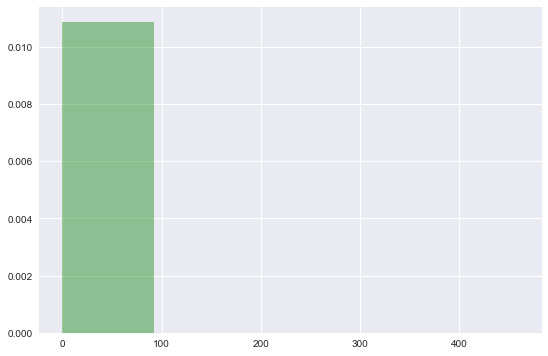

In [8]:
import seaborn as sns

plt.figure(figsize=(9, 6))
sns.distplot(df['qty'], color='g', bins=5, hist_kws={'alpha': 0.4})

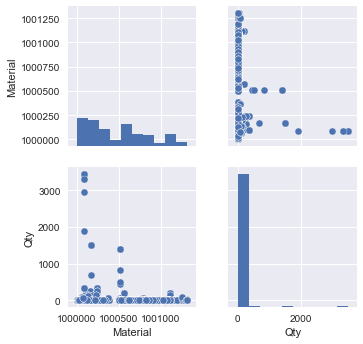

In [55]:
sns.pairplot(df)

In [57]:
df_num_corr = df.corr()['Qty'][:-1] # -1 because the latest row is SalePrice
#golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
#print("There is {} strongly correlated values with Qty:\n{}".format(len(golden_features_list), golden_features_list))

df_num_corr

Material   -0.097348
Name: Qty, dtype: float64

ValueError: First argument must be a sequence

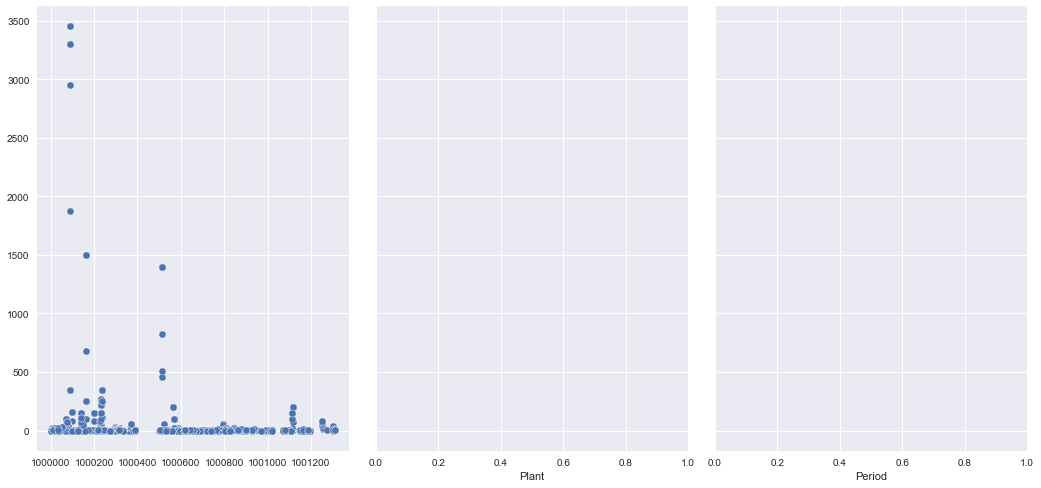

In [23]:
sns.pairplot(df, x_vars= ['Material', 'Plant', 'Period'], y_vars='Qty', size=7, aspect=0.7)

In [3]:
#df.date = pd.to_datetime(df.date)
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [4]:
dum = ['material', 'plant']
df2 = df[dum]

In [5]:
dummy = pd.get_dummies(df2)

In [6]:
dummy['customer'] = df['customer']
dummy['qty'] = df['qty']
dummy['date'] = df['date']
dummy.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty,date
0,1000000,1,0,0,0,0,0,0,0,0,1000605,1.80,2017-05-31
1,1000000,1,0,0,0,0,0,0,0,0,1000605,0.92,2017-06-03
2,1000000,1,0,0,0,0,0,0,0,0,1000605,0.08,2017-06-06
3,1000000,1,0,0,0,0,0,0,0,0,1000605,0.16,2017-06-09
4,1000000,1,0,0,0,0,0,0,0,0,1000605,2.34,2017-06-13


In [7]:
dummy = dummy.set_index('date')
dummy.sort_index(ascending = True, inplace = True)
dummy.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty
date,,,,,,,,,,,,
2018-02-15,1000341,1,0,0,0,0,0,0,0,0,1001199,2.00
2018-02-15,1000341,1,0,0,0,0,0,0,0,0,1001462,1.75
2018-02-15,1000223,0,1,0,0,0,0,0,0,0,1000744,0.10
2018-02-15,1000314,0,1,0,0,0,0,0,0,0,1001278,0.10
2018-02-15,1000246,0,0,1,0,0,0,0,0,0,1000902,0.12


In [8]:
dummy.index = pd.to_datetime(dummy.index)

In [9]:
temp = dummy.ix[(dummy.index.month != 2)]

In [10]:
temp.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty
date,,,,,,,,,,,,
2018-01-31,1000875,0,0,0,0,0,0,1,0,0,1003594,0.800
2018-01-31,1000804,0,0,0,0,0,0,1,0,0,1003996,0.002
2018-01-31,1000307,0,1,0,0,0,0,0,0,0,1000718,0.000
2018-01-31,1000307,0,1,0,0,0,0,0,0,0,1001897,0.000
2018-01-31,1000804,0,0,0,0,0,0,1,0,0,1004083,0.002


In [40]:
predictors = dummy.columns.difference(['Qty'])
x = dummy[predictors]
y = dummy['Qty']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 10)

In [41]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
#reg.fit(x_train, y_train)

In [12]:
preds = reg.predict(x_test)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [29]:
reg.score(x_test, y_test)

0.0012077551752793791

In [42]:
from sklearn import model_selection
scoring = 'r2'
results = model_selection.cross_val_score(reg, x, y, cv= 10, scoring=scoring)

In [43]:
results.mean()

-0.72038288129162686

In [60]:
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

In [61]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [63]:
results = model_selection.cross_val_score(svr, x, y, scoring=scoring)

In [64]:
results.mean()

0.009119970388738019

In [65]:
results = model_selection.cross_val_score(kr, x, y, cv= 10, scoring=scoring)

In [66]:
results.mean()

-0.18346950083094257

In [39]:
import numpy as np
import pyflux as pf
#from pandas.io.data import DataReader
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

ibm = data.DataReader(['JPM','GS','BAC','C','WFC','MS'],  'google', datetime(2012,1,1), datetime(2017,12,31))
opening_prices = np.log(ibm['Open'])


In [40]:
opening_prices.head()

,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2012-01-03,1.749200,3.300640,4.532277,3.528124,2.757475,3.330059
2012-01-04,1.742219,3.333632,4.551031,3.539219,2.756840,3.344274
2012-01-05,1.749200,3.319987,4.542763,3.547028,2.746630,3.349904
2012-01-06,1.826161,3.355502,4.541165,3.574871,2.777576,3.361763
2012-01-09,1.834180,3.357594,4.537854,3.567841,2.772589,3.372455


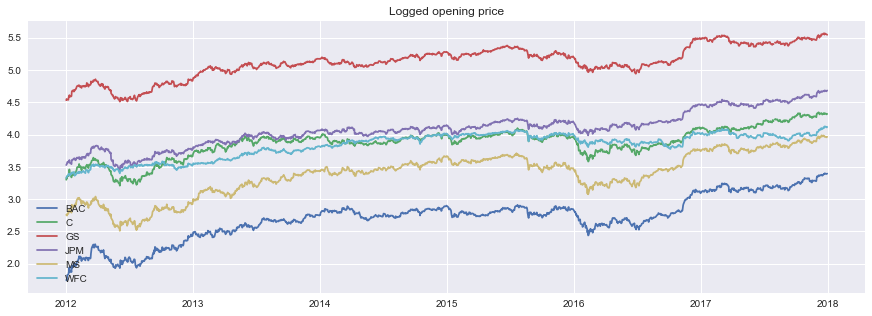

In [41]:
plt.figure(figsize=(15,5));
plt.plot(opening_prices.index,opening_prices);
plt.legend(opening_prices.columns.values,loc=3);
plt.title("Logged opening price");

In [51]:
#model = pf.VAR(data=opening_prices, lags=10, integ=1)
#x = model.fit()
#x.summary()

In [4]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv")
data.index = data['time'];
data.loc[(data['time']>=1983.05), 'seat_belt'] = 1;
data.loc[(data['time']<1983.05), 'seat_belt'] = 0;
data.loc[(data['time']>=1974.00), 'oil_crisis'] = 1;
data.loc[(data['time']<1974.00), 'oil_crisis'] = 0;

data.head()

,Unnamed: 0,time,drivers,seat_belt,oil_crisis
time,,,,,
1969.000000,1,1969.000000,1687,0.0,0.0
1969.083333,2,1969.083333,1508,0.0,0.0
1969.166667,3,1969.166667,1507,0.0,0.0
1969.250000,4,1969.250000,1385,0.0,0.0
1969.333333,5,1969.333333,1632,0.0,0.0


In [27]:
model = pf.ARIMAX(data=data, formula='drivers~1+seat_belt+oil_crisis',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: drivers                             Method: MLE                                       
Start Date: 1969.08333333333                            Log Likelihood: -1278.7663                        
End Date: 1984.91666666667                              AIC: 2569.5327                                    
Number of observations: 191                             BIC: 2589.0463                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.5003     0.0933     5.3615   0.0      (0.3174 | 0.6831)        
MA(1)                                

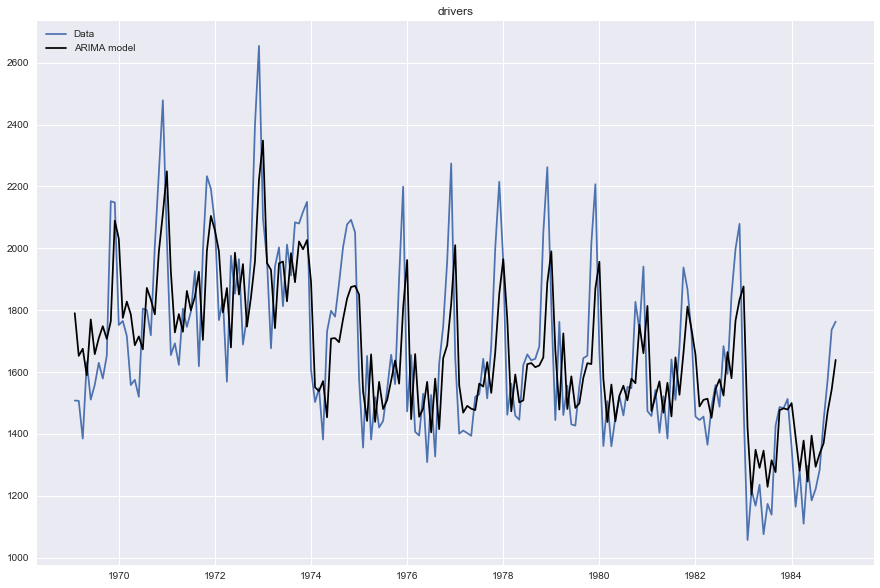

In [28]:
model.plot_fit(figsize=(15,10))

In [19]:
dummy.columns

Index(['material', 'plant_MY11', 'plant_MY21', 'plant_MY31', 'plant_MY41',
       'plant_PH11', 'plant_SG11', 'plant_VN11', 'plant_VN12', 'plant_VN21',
       'qty', 'date', 'customer'],
      dtype='object')

In [38]:
dummy.columns = ['material', 'plant_MY11', 'plant_MY21', 'plant_MY31', 'plant_MY41',
       'plant_PH11', 'plant_SG11', 'plant_VN11', 'plant_VN12', 'plant_VN21',
       'qty', 'date', 'customer']

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12, freq= 'M')
    rolstd = pd.rolling_std(timeseries, window=12, freq= 'M')

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    adf_results = {}
    for col in timeseries.columns.values:  #or edit this for a subset of columns first
        adf_results[col] = adfuller(timeseries[col])
    
    print (adf_results)
        
    
    #print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','critical value','Number of Observations Used'])
    #for key,value in dftest[4].items():
        #dfoutput['Critical Value (%s)'%key] = value
    #print (dfoutput)

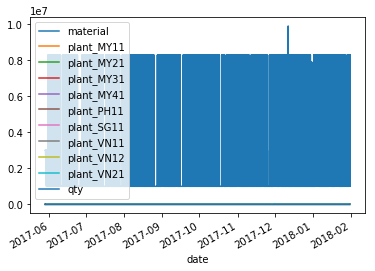

In [12]:
plt.figure(figsize=(35,35))
temp.plot()
plt.show()

In [13]:
test_stationarity(dummy)

ValueError: cannot reindex from a duplicate axis

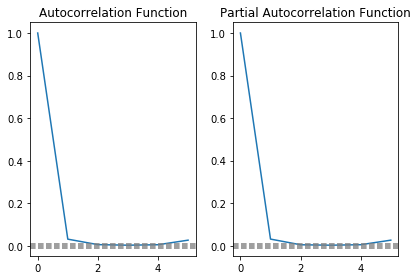

In [14]:
lag_acf = acf(dummy['qty'], nlags=5)
lag_pacf = pacf(dummy['qty'], nlags=5, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [19]:
import pyflux as pf
model = pf.ARIMAX(data=temp, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=2, ma=2, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(2,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-05-29 00:00:00                         Log Likelihood: -536976.1813                      
End Date: 2018-01-31 00:00:00                           AIC: 1073984.3627                                 
Number of observations: 54965                           BIC: 1074126.9939                                 
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0        0.0151     0.0      1.0      (-0.0295 | 0.0295)       
AR(2)                                

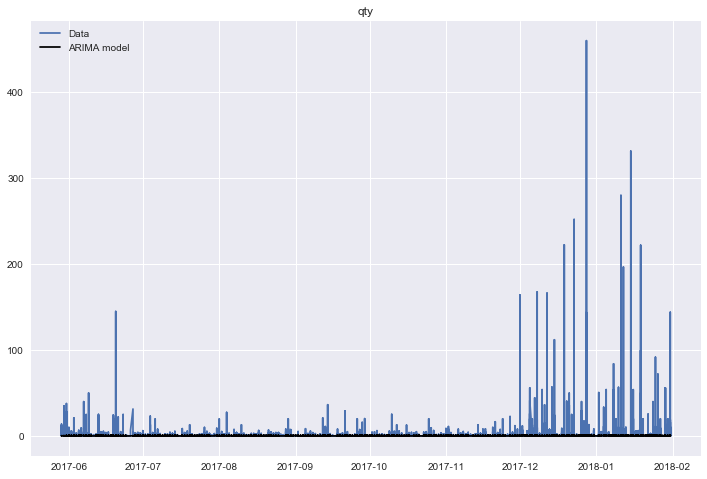

In [20]:
model.plot_fit(figsize=(12,8))

In [15]:
monthly = temp.resample('M').mean()
monthly.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2017-05-31,1.796847e+06,0.479339,0.206612,0.090909,0.066116,0.0,0.157025,0.0,0.0,0.0,2.435009
2017-06-30,1.244814e+06,0.615838,0.141678,0.129691,0.108862,0.0,0.003930,0.0,0.0,0.0,0.395418
2017-07-31,1.228752e+06,0.625747,0.142303,0.120174,0.109837,0.0,0.001938,0.0,0.0,0.0,0.208606
2017-08-31,1.185917e+06,0.580740,0.162863,0.135028,0.119467,0.0,0.001902,0.0,0.0,0.0,0.229003
2017-09-30,1.235742e+06,0.615728,0.149598,0.117962,0.114209,0.0,0.002502,0.0,0.0,0.0,0.235733


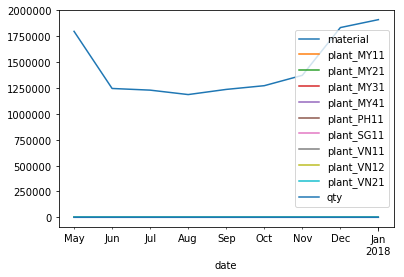

In [16]:
plt.figure(figsize=(35,35))
monthly.plot()
plt.show()

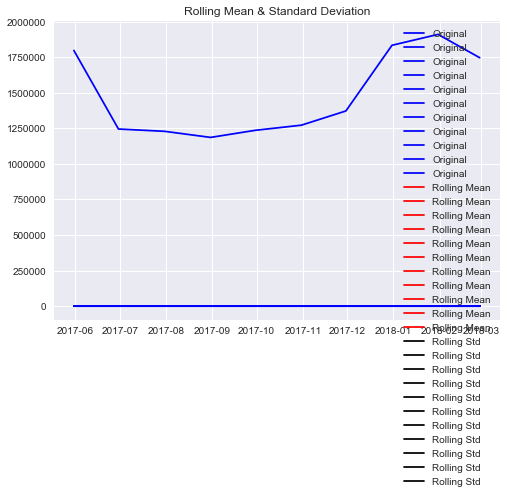

{'material': (0.0, 0.958532086060056, 5, 4, {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}, -inf), 'plant_MY11': (-0.0, 0.958532086060056, 6, 3, {'1%': -10.41719074074074, '5%': -5.77838074074074, '10%': -3.391681111111111}, -158.06586356268807), 'plant_MY21': (-0.3086538856319643, 0.9242697090531503, 3, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, -153.9069804793284), 'plant_MY31': (-0.0, 0.958532086060056, 5, 4, {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}, -155.29327484044828), 'plant_MY41': (-0.0, 0.958532086060056, 7, 2, {'1%': -20.825625000000002, '5%': -10.37019, '10%': -4.03822}, -151.13439175708862), 'plant_PH11': (-1.0019229092397517, 0.7525623182750202, 3, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, -160.83845228492785), 'plant_SG11': (-1.630647230925979, 0.46715194482347305, 1, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}

In [59]:
test_stationarity(monthly)

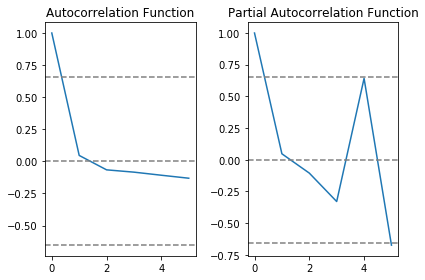

In [17]:
lag_acf = acf(monthly['qty'], nlags=5)
lag_pacf = pacf(monthly['qty'], nlags=5, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [18]:
import pyflux as pf
model = pf.ARIMAX(data=monthly, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=2, ma=3, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(2,0,3)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-08-31 00:00:00                         Log Likelihood: 6.887                             
End Date: 2018-01-31 00:00:00                           AIC: 20.226                                       
Number of observations: 6                               BIC: 16.6859                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0087     88453.6436 0.0      1.0      (-173369.1327 | 173369.15
AR(2)                                

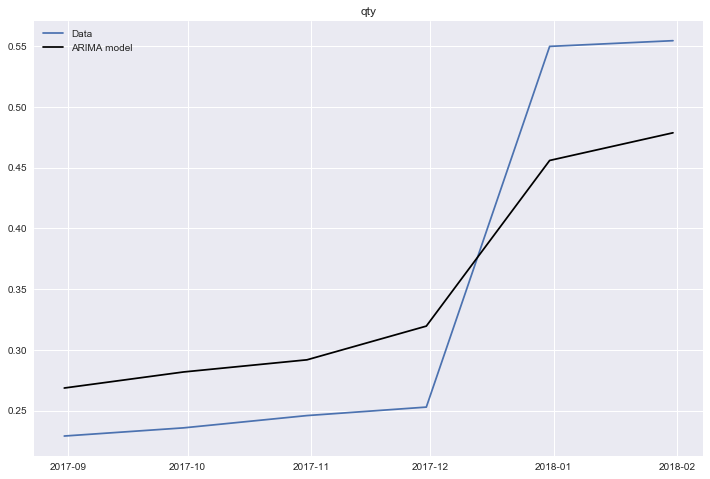

In [19]:
model.plot_fit(figsize=(12,8))

In [37]:
model.plot_predict(h=5, fit_once = False, fit_method = 'MLE')

PatsyError: Error evaluating factor: TypeError: 'NoneType' object is not subscriptable
    qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21
                              ^^^^^^^^^^

In [20]:
preds = model.predict(h = 6, oos_data = monthly, intervals=False)
accuracy = (preds['qty']/monthly.qty)*100
#accuracy = ((preds['qty'] - monthly.qty)/monthly.qty)*100
np.mean(accuracy)

105.49312471696533

In [23]:
monthly.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2017-05-31,1.796847e+06,0.479339,0.206612,0.090909,0.066116,0.0,0.157025,0.0,0.0,0.0,2.435009
2017-06-30,1.244814e+06,0.615838,0.141678,0.129691,0.108862,0.0,0.003930,0.0,0.0,0.0,0.395418
2017-07-31,1.228752e+06,0.625747,0.142303,0.120174,0.109837,0.0,0.001938,0.0,0.0,0.0,0.208606
2017-08-31,1.185917e+06,0.580740,0.162863,0.135028,0.119467,0.0,0.001902,0.0,0.0,0.0,0.229003
2017-09-30,1.235742e+06,0.615728,0.149598,0.117962,0.114209,0.0,0.002502,0.0,0.0,0.0,0.235733


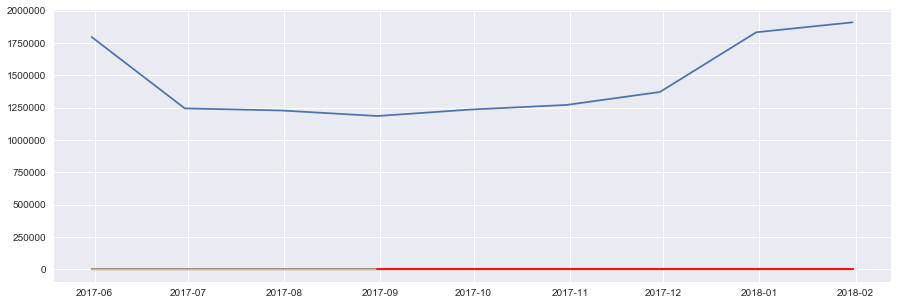

In [21]:
plt.figure(figsize=(15,5))
plt.plot(monthly)
plt.plot(preds, color = 'red')

In [43]:
start_date = monthly.index[0]
end_date = monthly.index[-1] + Day(3)
preds = model.predict(start_date.isoformat(), end_date.isoformat())

PatsyError: Error evaluating factor: TypeError: string indices must be integers
    qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21
                              ^^^^^^^^^^

In [39]:
accuracy = (preds['qty']/monthly.qty)*100
#accuracy = ((preds['qty'] - monthly.qty)/monthly.qty)*100
np.mean(accuracy)

86.92985268799906

ValueError: x and y must have same first dimension, but have shapes (7,) and (11,)

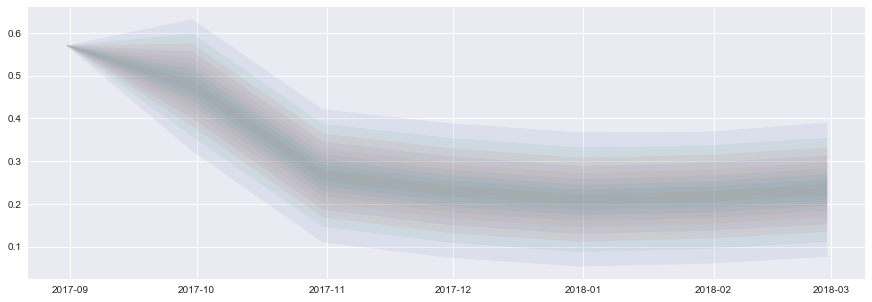

In [41]:
model.plot_predict(h=6, oos_data= monthly, past_values=5, figsize=(15,5))

In [45]:
weekly = temp.resample('W').mean()
weekly.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2018-01-07,1.784738e+06,0.247339,0.104571,0.080150,0.038197,0.016907,0.001252,0.346900,0.097683,0.067001,0.360160
2018-01-14,2.314166e+06,0.284110,0.059900,0.063644,0.064060,0.009983,0.004160,0.279950,0.175541,0.058652,0.769430
2018-01-21,1.805378e+06,0.301967,0.081266,0.058597,0.093242,0.018820,0.000000,0.293841,0.097519,0.054748,0.693475
2018-01-28,1.828030e+06,0.376693,0.065654,0.054165,0.036931,0.031596,0.002052,0.276159,0.099302,0.057448,0.377622
2018-02-04,1.660863e+06,0.271007,0.121877,0.043149,0.062831,0.038607,0.005299,0.324754,0.075700,0.056775,0.477753


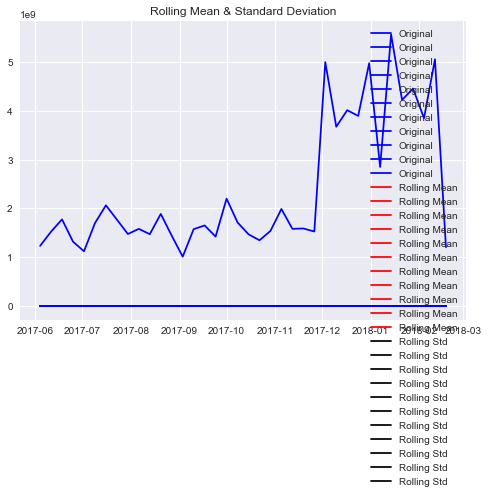

{'material': (-1.5688219929051337, 0.4992336631228387, 6, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 1196.301028602357), 'plant_MY11': (-5.067608046810719, 1.628118199740153e-05, 0, 37, {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}, 359.08251209975936), 'plant_MY21': (-4.123331183146246, 0.0008860055925573308, 3, 34, {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}, 278.81337740447714), 'plant_MY31': (-6.514887860125989, 1.0774866588763257e-08, 0, 37, {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}, 264.1939815725335), 'plant_MY41': (-5.2710203271875375, 6.285514215962988e-06, 1, 36, {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}, 277.82379368425643), 'plant_PH11': (-1.5132736542308824, 0.5269351316476396, 10, 27, {'1%': -3.6996079738860943, '5%': -2.9764303469999494, '10%': -2.627601001371742}, 246.4290029

In [216]:
test_stationarity(weekly)

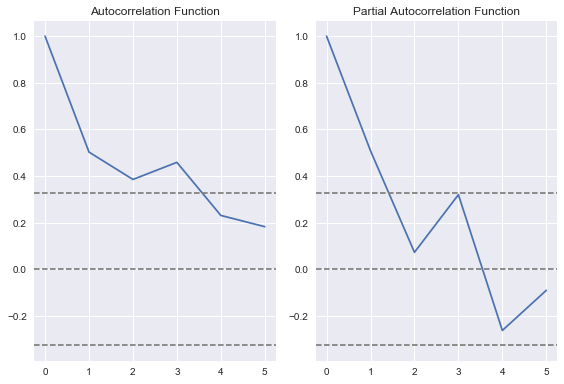

In [40]:
lag_acf = acf(weekly['qty'], nlags=5)
lag_pacf = pacf(weekly['qty'], nlags=5, method='ols')

#Plot ACF: 
plt.subplot(121) 
#plt.figure(figsize=(15,10))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
#plt.figure(figsize=(15,10))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [51]:
import pyflux as pf
model = pf.ARIMAX(data=weekly, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=8, ma=4, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(8,0,4)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-07-30 00:00:00                         Log Likelihood: 28.8984                           
End Date: 2018-02-04 00:00:00                           AIC: -9.7969                                      
Number of observations: 28                              BIC: 22.176                                       
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0197     1.9649     0.01     0.992    (-3.8316 | 3.871)        
AR(2)                                

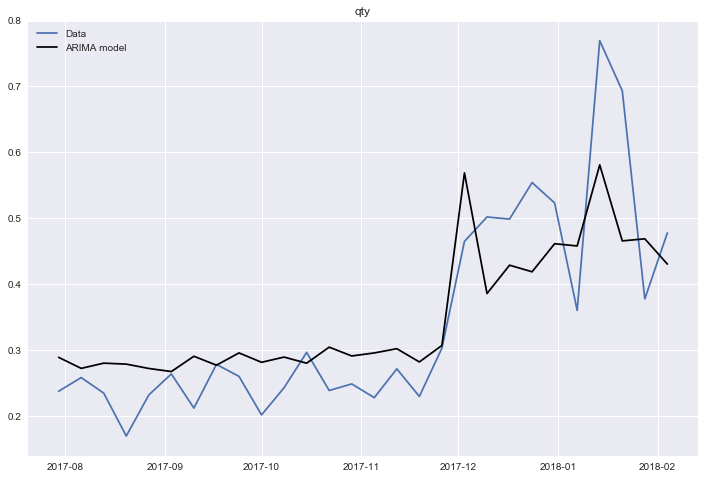

In [52]:
model.plot_fit(figsize=(12,8))

In [58]:
preds = model.predict(h = 3, oos_data = weekly, intervals=False)
preds

,qty
date,
2018-02-11,0.352529
2018-02-18,0.308496
2018-02-25,0.326899


In [71]:
preds = model.predict_is(h =20, intervals=False)
accuracy = (preds['qty']/weekly.qty)*100
#accuracy = ((preds['qty'] - weekly.qty)/monthly.qty)*100
np.mean(accuracy)

81.6104053284869

In [62]:
weekly.shape

(36, 11)

In [68]:
t = model.predict_is(h=20, intervals=False)
t

,qty
date,
2017-09-24,0.243825
2017-10-01,0.234949
2017-10-08,0.239570
2017-10-15,0.234330
2017-10-22,0.247482
2017-10-29,0.242348
2017-11-05,0.242755
2017-11-12,0.246296
2017-11-19,0.235859


In [29]:
dummy.index = pd.to_datetime(dummy.index)
temp = dummy.ix[(dummy.index.month != 2)]

temp.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty
date,,,,,,,,,,,,
2018-01-31,1000875,0,0,0,0,0,0,1,0,0,1003594,0.800
2018-01-31,1000804,0,0,0,0,0,0,1,0,0,1003996,0.002
2018-01-31,1000307,0,1,0,0,0,0,0,0,0,1000718,0.000
2018-01-31,1000307,0,1,0,0,0,0,0,0,0,1001897,0.000
2018-01-31,1000804,0,0,0,0,0,0,1,0,0,1004083,0.002


In [29]:
import pandas
pandas.__version__

'0.22.0'

In [30]:
test = pd.DataFrame()

In [53]:
test['S.No.']= [1,2,3,4]
test['Date'] = ['Feb-09',
'Sep-09','Dec-09', 'Sep-10']
test.head()

,S.No.,Date
0,1,Feb-09
1,2,Sep-09
2,3,Dec-09
3,4,Sep-10


In [54]:
pd.to_datetime(test['Date'])

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-02-09 00:00:00

In [76]:
!pip install pyflux

  Running setup.py bdist_wheel for pyflux: started
  Running setup.py bdist_wheel for pyflux: still running...
  Running setup.py bdist_wheel for pyflux: finished with status 'done'
  Stored in directory: C:\Users\Shantanu\AppData\Local\pip\Cache\wheels\f3\0b\3a\d0ce7bc6319a211207797e509bf7b1111561783e5b375382c2
  Running setup.py bdist_wheel for algopy: started
  Running setup.py bdist_wheel for algopy: finished with status 'done'
  Stored in directory: C:\Users\Shantanu\AppData\Local\pip\Cache\wheels\a8\10\95\73b328ebe0eedcb51969b60f93c7d94c9babd9762c7b2ab3a5
Successfully built pyflux algopy


In [81]:
!pip install pandas_datareader

  Running setup.py bdist_wheel for requests-ftp: started
  Running setup.py bdist_wheel for requests-ftp: finished with status 'done'
  Stored in directory: C:\Users\Shantanu\AppData\Local\pip\Cache\wheels\76\fb\0d\1026eb562c34a4982dc9d39c9c582a734eefe7f0455f711deb
Successfully built requests-ftp


In [4]:
!pip install pandas

In [1]:
!pip install --upgrade statsmodels

  Running setup.py bdist_wheel for statsmodels: started
  Running setup.py bdist_wheel for statsmodels: finished with status 'done'
  Stored in directory: C:\Users\Shantanu\AppData\Local\pip\Cache\wheels\23\82\8a\d7f0a956c594584933bdedaacac68f7bc962020943496302a0
Successfully built statsmodels
  Found existing installation: statsmodels 0.6.1
    Uninstalling statsmodels-0.6.1:
      Successfully uninstalled statsmodels-0.6.1
